<a href="https://colab.research.google.com/github/insaiyancvk/Computer-Vision/blob/main/Image_colorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Let the Image Colorization begin!

## Download and unzip the dataset

In [ ]:
# !wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
!cp "/content/drive/MyDrive/colorize dataset/testSetPlaces205_resize.tar.gz" /content/
!tar -xzf testSetPlaces205_resize.tar.gz

In [41]:
# Plotting tools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Conversion tools
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# The G
import torch
import torch.nn as nn
import torch.nn.functional as F
# For the model
import torchvision.models as models
from torchvision import datasets, transforms
# other utilities
import os, shutil, time
import pandas as pd
from IPython.display import Image, display
# Check for GPU
use_gpu = torch.cuda.is_available()

In [17]:
dataset = pd.read_csv('imgList.csv', header=None)

In [19]:
os.makedirs('images/train/', exist_ok=True) # 40000 images
os.makedirs('images/test/', exist_ok=True) # 1000 images

In [33]:
for i in dataset[:1000][0]:
  shutil.move('testSet_resize/'+i, 'images/test/')
for i in dataset[1000:][0]:
  shutil.move('testSet_resize/'+i, 'images/train/')

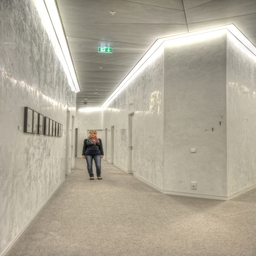

In [37]:
display(Image(filename='images/test/'+dataset[0][0]))

# Define the model

In [61]:
class Colorizer(nn.Module):
  def __init__(self, input_size = 128):
    super(Colorizer, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half of the ResNet (18)
    resnet = models.resnet18(num_classes=365)
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    # Extract mid-level featurees from the ResNet
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(
        nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    return self.upsample(midlevel_features)

In [44]:
# playing around
resnet = models.resnet18(num_classes=365)
nn.Sequential(*list(resnet.children()))

In [62]:
model = Colorizer()